In [11]:
import  os
import  numpy as np
import  pandas as pd
import  matplotlib.pyplot as plt
import  seaborn as sns
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [12]:
df = pd.read_csv('../data_preprocessing/Merged_data/002_verwaltung_with_holidays_indoor_person_counts.csv')
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y-%m-%d %H:%M:%S')

In [13]:
df.set_index('DateTime',inplace=True)

In [14]:
df = df.astype({'is_holiday': 'int32', 'day_of_week': 'int32', 'hour_of_day': 'int32', 'is_working_hour': 'int32'})

In [15]:
# Define the date ranges for training and test data
train_end_date = df.index.min() + pd.DateOffset(months=9)
test_start_date = train_end_date

# Split the DataFrame
train_data = df[:train_end_date]
test_data = df[test_start_date:]

In [16]:
df

,electricity_15min_diff,heating_15min_diff,is_holiday,day_of_week,hour_of_day,is_working_hour,number_of_people,Temperature,Humidity,Dewpoint,Sun Duration,Precipitation Height,Wind Speed,Wind Direction,indoor_temperature,temperature_difference
DateTime,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,0.00,0.0,1,5,0,0,0,11.6,85.0,9.1,0.0,0.0,4.3,220.0,11.6,0.0
2022-01-01 00:15:00,1.38,5.0,1,5,0,0,0,11.6,85.0,9.1,0.0,0.0,4.3,220.0,11.6,0.0
2022-01-01 00:30:00,1.20,5.0,1,5,0,0,0,11.6,85.0,9.1,0.0,0.0,4.3,220.0,11.6,0.0
2022-01-01 00:45:00,1.37,5.0,1,5,0,0,0,11.6,85.0,9.1,0.0,0.0,4.3,220.0,11.6,0.0
2022-01-01 01:00:00,1.15,5.0,1,5,1,0,0,11.5,85.0,9.1,0.0,0.0,4.2,220.0,11.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 23:00:00,2.12,3.0,1,5,23,0,0,12.9,70.0,7.5,0.0,0.0,4.0,240.0,12.9,0.0
2022-12-31 23:15:00,1.64,2.0,1,5,23,0,0,12.9,70.0,7.5,0.0,0.0,4.0,240.0,12.9,0.0
2022-12-31 23:30:00,1.87,3.0,1,5,23,0,0,12.9,70.0,7.5,0.0,0.0,4.0,240.0,12.9,0.0


In [17]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import uniform

# Prepare the data
input_cols = [  'is_holiday',
       'day_of_week', 'hour_of_day', 'is_working_hour', 'number_of_people',
       'Temperature', 'Humidity', 'Dewpoint', 'Sun Duration',
       'Precipitation Height', 'Wind Speed', 'Wind Direction',
       'indoor_temperature', 'temperature_difference']
target_col = 'heating_15min_diff'# Prepare the data

# Assuming train_data and test_data are already loaded DataFrames
X_train = train_data[input_cols]
y_train = train_data[target_col]
X_test = test_data[input_cols]
y_test = test_data[target_col]

# 定义参数分布
param_dist = {
    'C': uniform(0.1, 10),  # 使用均匀分布
    'epsilon': uniform(0.01, 0.1),
    'kernel': ['rbf'],
    'gamma': ['scale'],
}

# 定义评分函数
scoring = make_scorer(mean_squared_error, greater_is_better=False)

# Initialize the TimeSeriesSplit with the desired number of splits
tscv = TimeSeriesSplit(n_splits=2)

# 初始化 RandomizedSearchCV
random_search = RandomizedSearchCV(SVR(), param_distributions=param_dist, scoring=scoring, n_iter=10, cv=tscv, n_jobs=1, random_state=42)

# 拟合 RandomizedSearchCV 到训练数据
random_search.fit(X_train, y_train)

# 获取最佳参数
best_params = random_search.best_params_
print(f'Best parameters found: {best_params}')

Best parameters found: {'C': 7.41993941811405, 'epsilon': 0.06986584841970366, 'gamma': 'scale', 'kernel': 'rbf'}


In [18]:
# Train the SVR model
svr = SVR(**best_params)
svr.fit(X_train, y_train)

# Make predictions
y_pred = svr.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R² Score: {r2:.4f}')

MSE: 1.8268
RMSE: 1.3516
MAE: 1.0639
R² Score: 0.6225


In [19]:
# # Prepare the data
# input_cols = [ 'is_holiday',
#        'day_of_week', 'hour_of_day', 'is_working_hour', 'Temperature',
#        'Humidity', 'Dewpoint', 'Sun Duration', 'Precipitation Height',
#        'Wind Speed', 'Wind Direction']
# target_col = 'heating_15min_diff'
# 
# # Assuming train_data and test_data are already loaded DataFrames
# X_train = train_data[input_cols]
# y_train = train_data[target_col]
# X_test = test_data[input_cols]
# y_test = test_data[target_col]
# 
# # Train the SVR model
# svr = SVR(kernel='rbf')
# svr.fit(X_train, y_train)
# 
# # Make predictions
# y_pred = svr.predict(X_test)
# 
# # Evaluate the model
# mse = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)
# mae = mean_absolute_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# 
# print(f'MSE: {mse:.4f}')
# print(f'RMSE: {rmse:.4f}')
# print(f'MAE: {mae:.4f}')
# print(f'R² Score: {r2:.4f}')

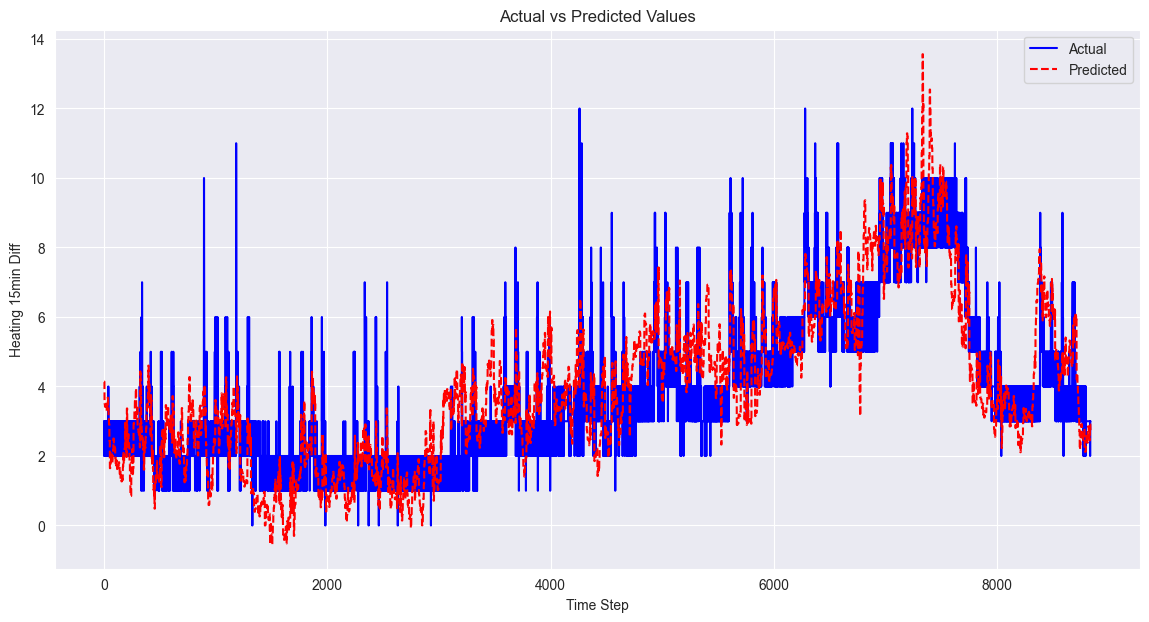

In [20]:
# Assuming `y_test` and `y_pred` are your actual and predicted values respectively

# Convert to numpy arrays if they are not already
y_test = np.array(y_test)
y_pred = np.array(y_pred)

# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual', color='b')
plt.plot(y_pred, label='Predicted', color='r', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Heating 15min Diff')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()